In [8]:
# %pip install segmentation-models-pytorch


In [9]:
import os
import cv2
import numpy as np
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp


In [10]:
class ChartSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path  = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir,  self.images[idx])
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Convert mask: 255 = ignore, 100 = resistance, 0 = support
        mask_out = np.full_like(mask, fill_value=0)     # background
        mask_out[mask == 100] = 1                       # resistance
        mask_out[mask == 0] = 2                         # support

        if self.transforms:
            augmented = self.transforms(image=image, mask=mask_out)
            image, mask = augmented["image"], augmented["mask"]

        return image, mask.long()


In [11]:
def get_loader(image_dir, mask_dir, batch_size=8, shuffle=True):
    transforms = A.Compose([
        A.Resize(640, 640),
        A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
        ToTensorV2()
    ])
    ds = ChartSegDataset(image_dir, mask_dir, transforms)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=0)


In [12]:
# Adjust paths as needed
train_loader = get_loader(
    image_dir="../dataset/images/train",
    mask_dir="../dataset/masks/train",
    batch_size=4
)

batch = next(iter(train_loader))
img, msk = batch

print("Image shape:", img.shape)  # [B, 3, H, W]
print("Mask shape :", msk.shape)  # [B, H, W]


Image shape: torch.Size([4, 3, 640, 640])
Mask shape : torch.Size([4, 640, 640])


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=3  # background, resistance, support
).to(device)

loss_fn = smp.losses.DiceLoss(mode='multiclass')
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/morgancooper/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


100%|██████████| 83.3M/83.3M [01:22<00:00, 1.06MB/s]


In [14]:
EPOCHS = 1

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        loss = loss_fn(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1} done — avg loss: {avg_loss:.4f}")


Epoch 1: 100%|██████████| 175/175 [16:47<00:00,  5.76s/it, loss=0.0181] 

✅ Epoch 1 done — avg loss: 0.0581


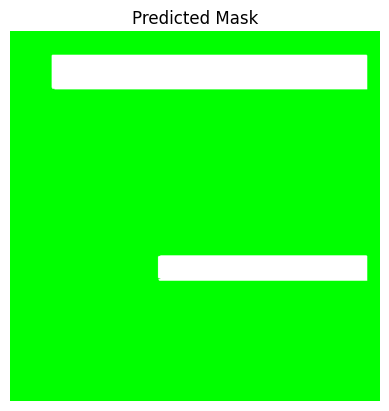

In [15]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --------- 1. Run model on a batch of images ---------
model.eval()
with torch.no_grad():
    for imgs, _ in train_loader:
        preds = model(imgs.to(device))  # [B, C, H, W] where C = 2
        break  # just one batch for demo

# --------- 2. Convert logits to predicted class IDs ---------
# Use argmax over channel dim to get class map
pred_masks = torch.argmax(preds, dim=1).cpu().numpy()  # [B, H, W]

# --------- 3. Pick one mask and convert to color ---------
# Define your color map: class 0 = white bg, 1 = red, 2 = green
colors = {
    0: (255, 255, 255),  # background: white
    1: (0, 0, 255),      # resistance: red
    2: (0, 255, 0),      # support: green
}

def mask_to_color(mask):
    color_img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for cls, color in colors.items():
        color_img[mask == cls] = color
    return color_img

# Pick the first prediction
pred_mask_np = pred_masks[0]
color_mask = mask_to_color(pred_mask_np)

# --------- 4. Save and View using OpenCV (via matplotlib) ---------
cv2.imwrite("predicted_mask.png", cv2.cvtColor(color_mask, cv2.COLOR_RGB2BGR))

# Show in notebook
plt.imshow(color_mask)
plt.axis("off")
plt.title("Predicted Mask")
plt.show()

